# Review classification

## Content

This is machine learning training with review classification case in the most e-Commerce corporation "Amazon". The data used are sourced from https://www.kaggle.com/eswarchandt/amazon-music-reviews


The following below is the main content of this notebook:
* Data Preparation
* Data processing 
* Standard Machine Learning Model
* Deep Learning Model (keras)
* Metrics Evaluation

Import packages

In [341]:

import numpy as np
import pandas as pd
import re, string

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#resampling
import imblearn

#natural language toolkit
import nltk 
nltk.download(['stopwords', 'wordnet'])
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc

##tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Preparation

In [262]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [263]:
#copy file from drive to local VM

%cp '/content/drive/My Drive/Dataset/amazon_musical_instruments_reviews.csv.zip' '/content/musical_review.zip'

In [264]:
#unzip file

from zipfile import ZipFile
local_zip = '/content/musical_review.zip'
zip_ref = ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [265]:
#read the data
data = pd.read_csv('/content/Musical_instruments_reviews.csv')

data.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

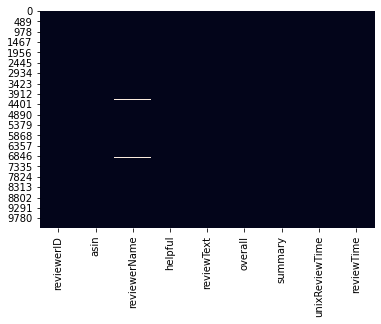

In [266]:
#check missing value
plot_missing = sns.heatmap(data.isnull(), cbar=False)
data.isnull().sum()

In [267]:
#fill missing value in the reviewText column with blank string
data.fillna("", inplace=True)

In [268]:
#drop unecessary attribute (columns)

data = data.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'], axis=1)
data.head(2)

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5.0,good
1,The product does exactly as it should and is q...,5.0,Jake


In [269]:
#create new column name 'text' with values from the result of concatenate reviewText and summary column
data['text'] = data['reviewText'] + ' ' + data['summary'] 

#drop reviewText and summary column
data = data.drop(['reviewText', 'summary'], axis=1)
data.head(2)

,overall,text
0,5.0,"Not much to write about here, but it does exac..."
1,5.0,The product does exactly as it should and is q...


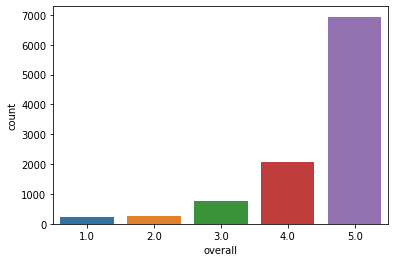

In [270]:
#Check value counts of overall column
value_count = data['overall']
sns.countplot(value_count)

In [271]:
#Change value of overall column. 1 for good sentiment with rating above 3, and 0 for bad sentiment with rating 1-3

def rating_to_sentiment(rating):
  if(int(rating) <= 3):
    return 0
  else:
    return 1

data['overall'] = data['overall'].apply(rating_to_sentiment)

#Check the value again
data['overall'].value_counts() 

1    9022
0    1239
Name: overall, dtype: int64

### Data processing

In [273]:
#Clean value in text column

pattern = re.compile('\d+')
stopword = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
translation_table = dict.fromkeys(map(ord, string.punctuation),' ')

def clean_data(text):
  """
    text: a string

    return: modified initial string
  """

  text = text.lower()
  text = text.translate(translation_table)
  text = pattern.sub(' ', text)
  word_list = text.split()
  text = ' '.join([w for w in word_list if w not in stopword])
  text = ' '.join([lemmatizer.lemmatize(word) for word in word_list])

  return text

data['text'] = data['text'].apply(clean_data)
#remove digit contains in text string

Data Splitting

In [316]:
X = data['text'].values
y = data['overall'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Standart Machine Learning Model


In [317]:
# feature extraction
tv = TfidfVectorizer()
tv_train = tv.fit_transform(X_train)
tv_test = tv.transform(X_test)

print("Tfidf train:", tv_train.shape)
print("Tfidf test:", tv_test.shape)

Tfidf train: (8208, 15811)
Tfidf test: (2053, 15811)


#### Logistic Regression Model

In [318]:
lr = LogisticRegression(class_weight='balanced', max_iter=200)

# fitting the model
lr_model = lr.fit(tv_train, y_train)
lr_predict = lr_model.predict(tv_test)

In [319]:
# model report
lr_report = classification_report(y_test, lr_predict)

print('lr original report:\n', lr_report)

lr original report:
               precision    recall  f1-score   support

           0       0.44      0.77      0.56       245
           1       0.96      0.87      0.91      1808

    accuracy                           0.85      2053
   macro avg       0.70      0.82      0.74      2053
weighted avg       0.90      0.85      0.87      2053



#### Multinomial Naive Bayes 

In [320]:
mnb = MultinomialNB()

# fitting the model
mnb_model = mnb.fit(tv_train, y_train)
mnb_predict = mnb_model.predict(tv_test)

In [321]:
# model report
mnb_report = classification_report(y_test, nb_predict)
print('naive bayes report:\n', mnb_report)

naive bayes report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       245
           1       0.88      1.00      0.94      1808

    accuracy                           0.88      2053
   macro avg       0.44      0.50      0.47      2053
weighted avg       0.78      0.88      0.82      2053



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Tree-based method (Random Forest)

Model fitting

In [323]:
rfc = RandomForestClassifier(n_estimators=200)

# fitting the model
rfc_model = rfc.fit(tv_train, y_train)
rfc_predict = rfc_model.predict(tv_test)

Classification report

In [324]:
# model report
rfc_report = classification_report(y_test, rfc_predict)
print('random forest classifier results report:\n', rfc_report)

random forest classifier results report:
               precision    recall  f1-score   support

           0       0.75      0.01      0.02       245
           1       0.88      1.00      0.94      1808

    accuracy                           0.88      2053
   macro avg       0.82      0.51      0.48      2053
weighted avg       0.87      0.88      0.83      2053



### Deep Learning (Keras)

In [325]:
NUM_OF_WORDS = 15000
EMBEDDING_DIM = 16

tokenizer = Tokenizer(num_words=NUM_OF_WORDS, oov_token='x')

tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sequences_train)
padded_test = pad_sequences(sequences_test)

In [326]:
#resampling strategy
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority')

padded_sm, y_sm = smote.fit_sample(padded_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [334]:
# create model architecture

def build_model():
  model = Sequential(
      [
      layers.Embedding(input_dim=NUM_OF_WORDS ,output_dim=EMBEDDING_DIM),
      layers.GlobalAveragePooling1D(),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1, activation='sigmoid')
      ]
  )
  
  #compile the model
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC()])
  return model

keras_model = build_model()

In [329]:
# model callbacks
class ModelCallbacks(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.9) and (logs.get('val_accuracy')>0.9)):
      print('\naccuracy has been reached more than 90%')
      self.model.stop_training = True

callbacks = ModelCallbacks()

In [335]:
# fit the model
num_epochs = 100
batch_size = 64
history = keras_model.fit(padded_sm,
          y_sm,
          epochs=num_epochs,
          batch_size = batch_size,
          validation_split=0.3,
          callbacks=[callbacks])

Epoch 1/100
158/158 [==============================] - 2s 14ms/step - loss: 0.6154 - accuracy: 0.7112 - auc_6: 0.5146 - val_loss: 1.1869 - val_accuracy: 0.0000e+00 - val_auc_6: 0.0000e+00
Epoch 2/100
158/158 [==============================] - 2s 13ms/step - loss: 0.5967 - accuracy: 0.7143 - auc_6: 0.5367 - val_loss: 1.2769 - val_accuracy: 0.0000e+00 - val_auc_6: 0.0000e+00
Epoch 3/100
158/158 [==============================] - 2s 12ms/step - loss: 0.5946 - accuracy: 0.7143 - auc_6: 0.5582 - val_loss: 1.1922 - val_accuracy: 4.6200e-04 - val_auc_6: 0.0000e+00
Epoch 4/100
158/158 [==============================] - 2s 13ms/step - loss: 0.5904 - accuracy: 0.7153 - auc_6: 0.5888 - val_loss: 1.3428 - val_accuracy: 0.0079 - val_auc_6: 0.0000e+00
Epoch 5/100
158/158 [==============================] - 2s 13ms/step - loss: 0.5804 - accuracy: 0.7179 - auc_6: 0.6487 - val_loss: 1.2967 - val_accuracy: 0.0372 - val_auc_6: 0.0000e+00
Epoch 6/100
158/158 [==============================] - 2s 13ms/step 

In [336]:
# evaluate the model
keras_predict = keras_model.predict(padded_test).ravel()
score, acc, auc = keras_model.evaluate(padded_test, y_test)
txt ='Accuracy: {}\nAUC: {}'
print(txt.format(acc, auc))

65/65 [==============================] - 0s 4ms/step - loss: 0.5088 - accuracy: 0.8544 - auc_6: 0.8039
Accuracy: 0.8543594479560852
AUC: 0.8039055466651917


### Metric evaluation (ROC)

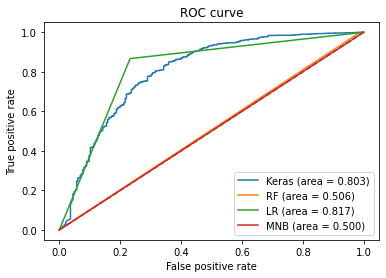

In [342]:
# ROC metrics
fpr_keras, tpr_keras, thresholds = roc_curve(y_test, keras_predict) #Keras
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, rfc_predict) #RandomForest
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, lr_predict) #LogisticRegression
fpr_mnb, tpr_mnb, thresholds = roc_curve(y_test, mnb_predict) #MultinomialNB

# AUC
auc_keras = auc(fpr_keras, tpr_keras)
auc_rf = auc(fpr_rf, tpr_rf)
auc_lr = auc(fpr_lr, tpr_lr)
auc_mnb = auc(fpr_mnb, tpr_mnb)

# plotting
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_lr, tpr_lr, label='LR (area = {:.3f})'.format(auc_lr))
plt.plot(fpr_mnb, tpr_mnb, label='MNB (area = {:.3f})'.format(auc_mnb))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()